# The Transparent Customer: Trees, Forests, and Ensembles!

## Setup

#### FOR GOOGLE COLLAB USERS ONLY: Mount Drive

### Import (Standard) Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

In [4]:
data = pd.read_csv("../Data/clean_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  float64
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  float64
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  float64
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  Month                          12330 non-null  float64
 11  OperatingSystems               12330 non-null  float64
 12  Browser                        12330 non-null 



*   No missing data
*   23 Features
* Some features are objects (text data). We need to transform them because scikit-learn cannot work with them



## Training and Evaluating a Decision Tree Classifier

### 1) Import Model Functions

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2) Define X and y

In [7]:
y = data["Revenue"]
X = data.drop("Revenue", axis=1)

### 3) Create Test & Training Data


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

### 4) Instantiate Model

In [11]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 2).fit(X_train, y_train)


### 6) Interpret Results


In [14]:
def plot_tree_classification(treemodel, X):
    from sklearn import tree
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(60,20))
    _ = tree.plot_tree(treemodel,filled=True,
                       class_names=['0','1'],
                       feature_names = X.columns,
                       proportion=True,precision=2)

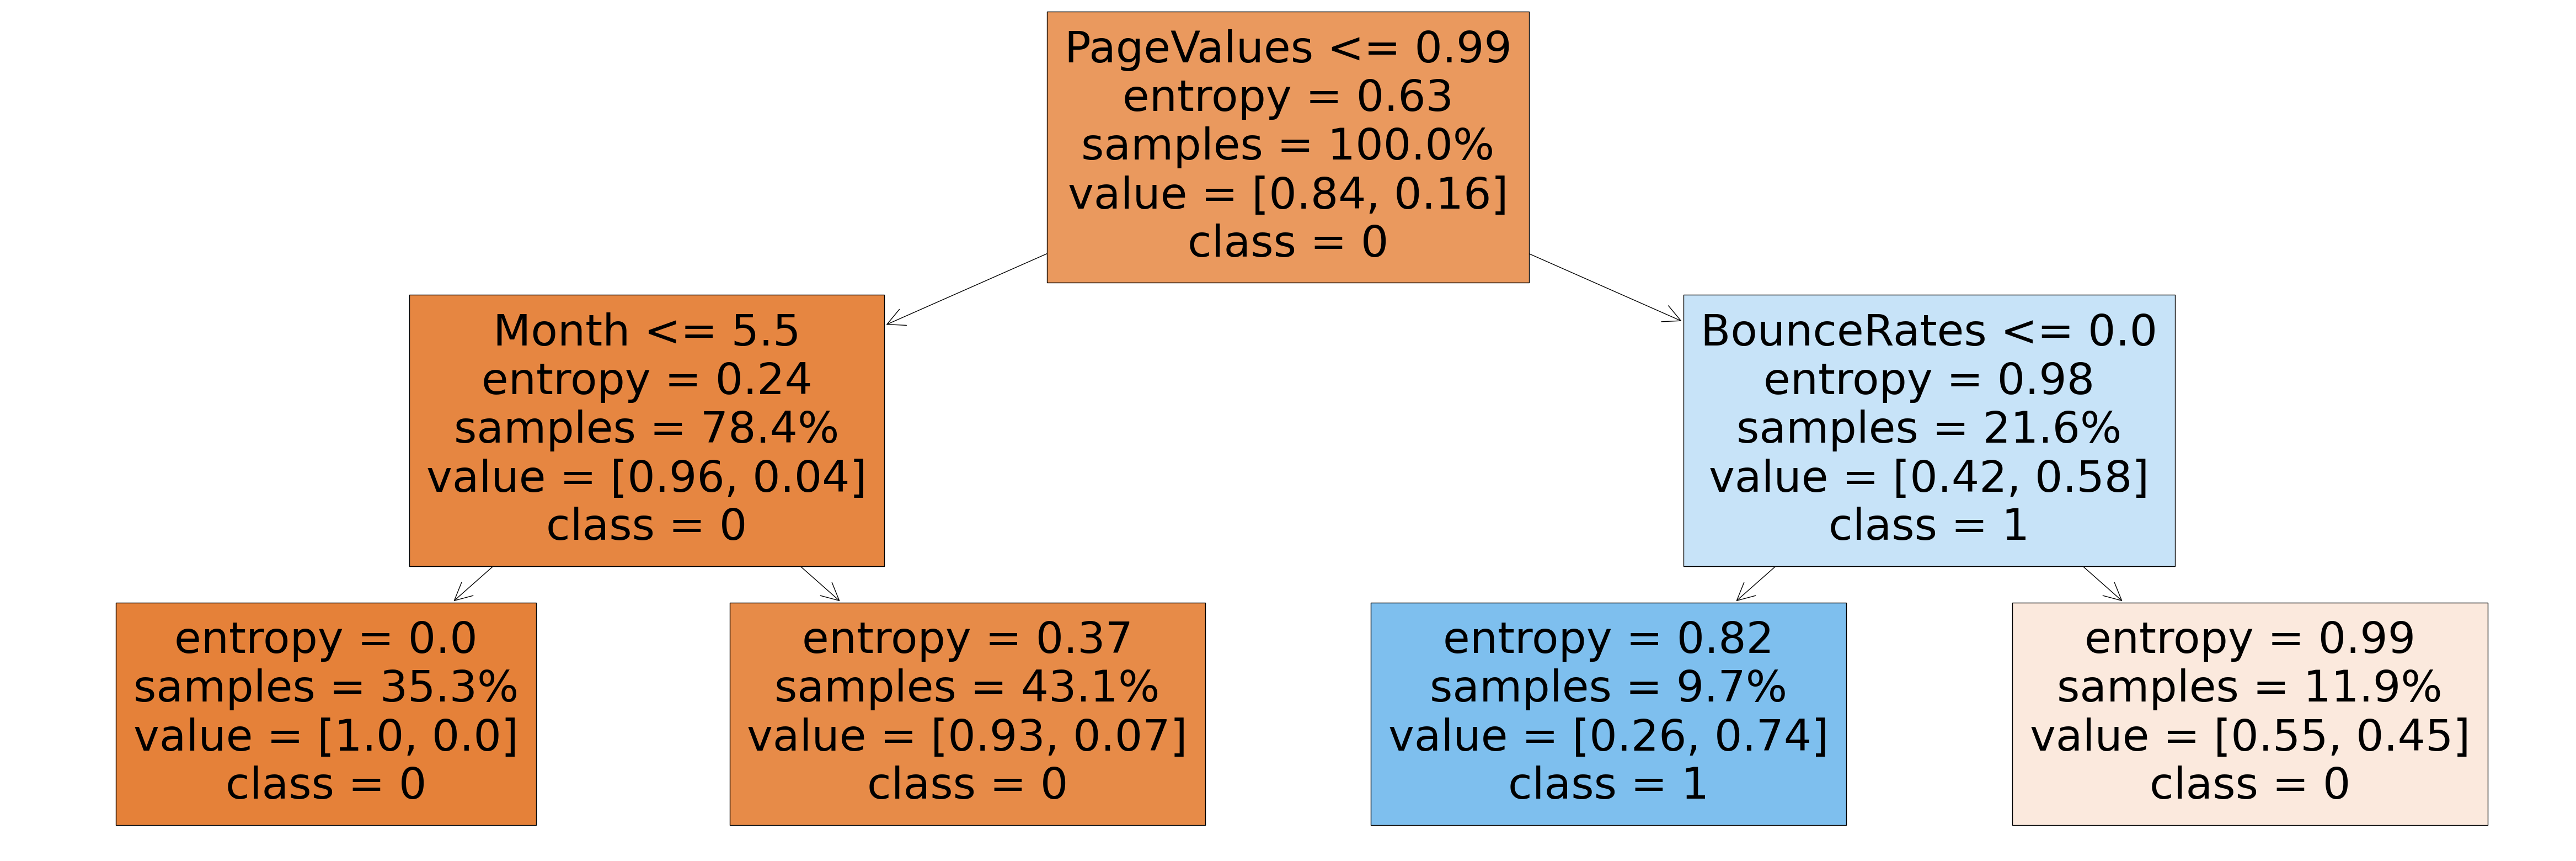

In [15]:
plot_tree_classification(tree, X_train)

### 7) Evaluate Generalization Performance

#### Investigating Performance Metrics

In scikit-learn, .predict() gets the predicted class . Sklearn is using a default threshold of 0.5. Every predicted probability that is higher is set to 1. Eevery predicted propability that is smaller is set to 0.

In [16]:
y_preds_class = tree.predict(X_test)
y_preds_class

array([0., 1., 0., ..., 0., 0., 0.])

We can also get the predicted probabilities with .preedict_proba(). We get two columents: One for the negative class (remain) and one for the positive class (churn). Both values sum up two 1. 

The positive class is in the second columm: 

In [17]:
y_preds_proba = tree.predict_proba(X_test)
y_preds_proba

array([[9.27668728e-01, 7.23312718e-02],
       [2.58026159e-01, 7.41973841e-01],
       [9.99671701e-01, 3.28299409e-04],
       ...,
       [9.27668728e-01, 7.23312718e-02],
       [9.99671701e-01, 3.28299409e-04],
       [9.99671701e-01, 3.28299409e-04]])

We can get predicted probabilities with the .predict_proba() method:

In [18]:
print(classification_report(y_test, y_preds_class))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      3149
         1.0       0.72      0.45      0.56       550

    accuracy                           0.89      3699
   macro avg       0.81      0.71      0.75      3699
weighted avg       0.88      0.89      0.88      3699



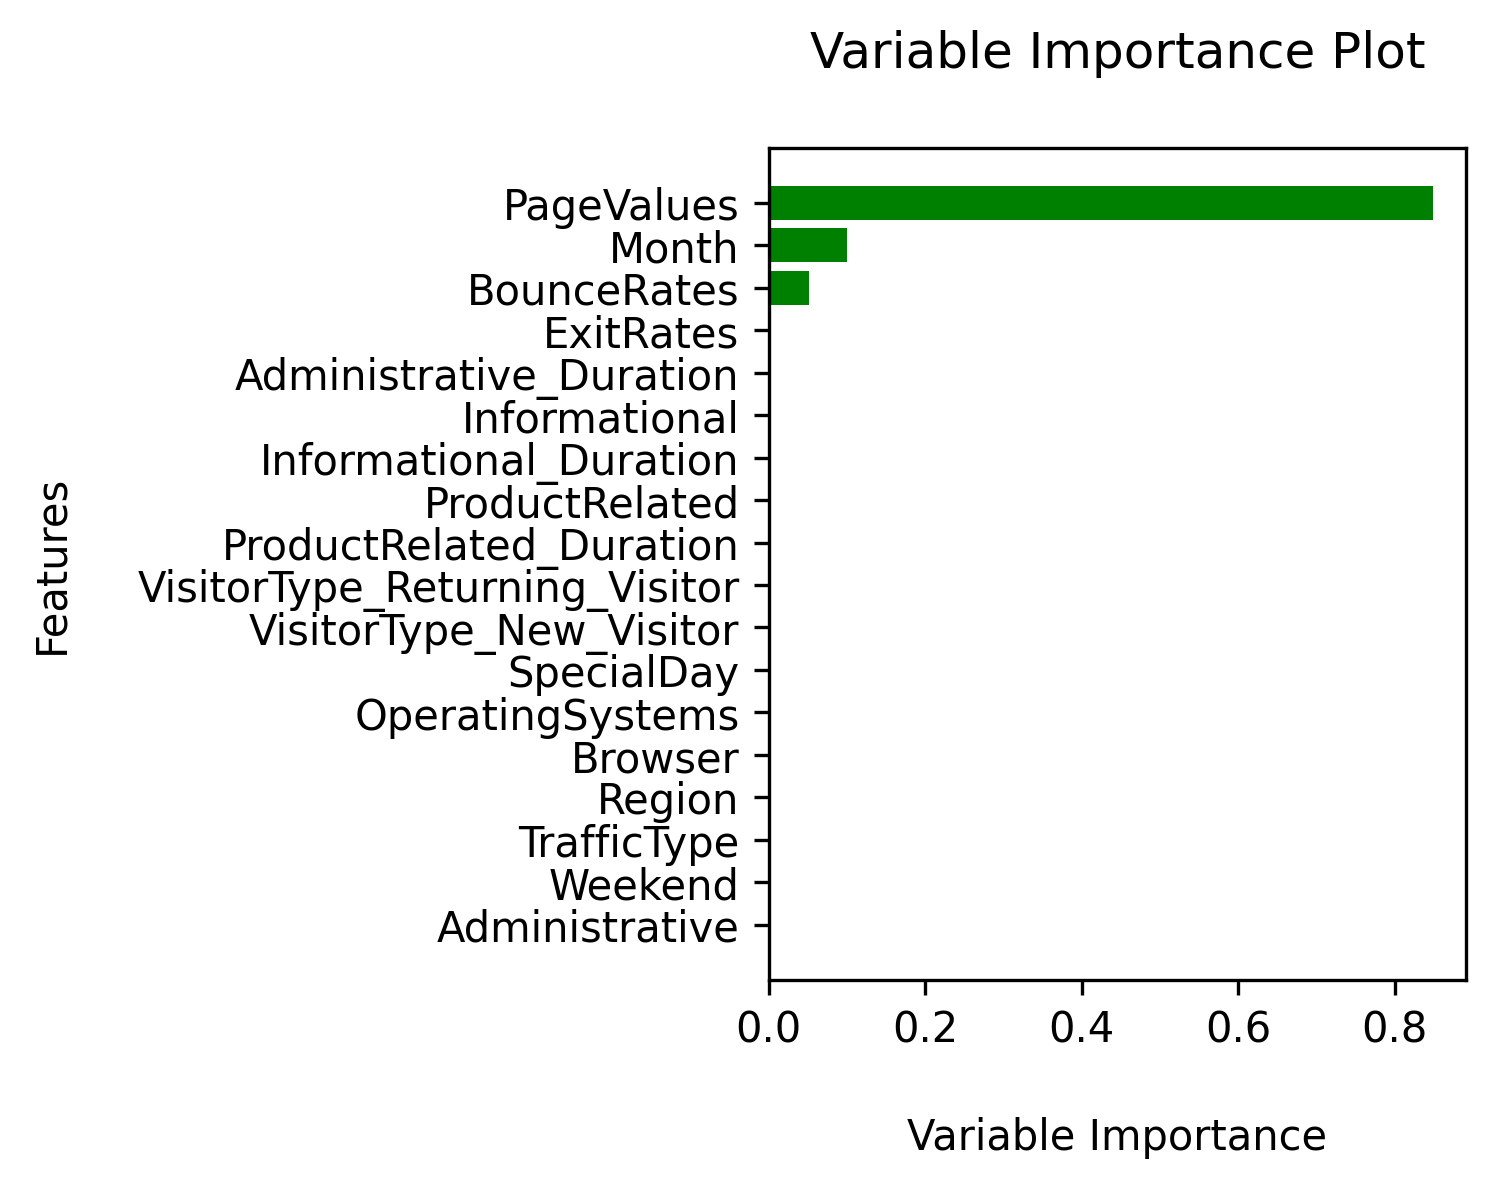

In [44]:
plot_variable_importance(tree, X_train)

### Plotting Lift Curve

In [19]:
def calculate_lift(y_val, y_pred):
    from pandas import DataFrame
    from numpy import ceil, arange
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = DataFrame()
    aux_lift['true'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted', ascending=False, inplace=True)
    
    #Create the values that will go into the X axis of our plot
    xval = arange(0.01,1.01,0.01) #create sequnence of values from 0.01 to 1.00 in steps of 0.01
    lift = [] #create empty list for storing lift values
    
    #Calculate the total ratio of true events in the data
    ratio_true_events_total = aux_lift['true'].sum() / len(aux_lift)
    
    #Calculate lift for each x value its correspondent y value
    for x in xval:
        index_xval = int(ceil(x*len(aux_lift))) #get index at specific value of x
        dataframe_xval = aux_lift.iloc[:index_xval,:]   #subset dataframe from 0 to index_val
        lift_xval = dataframe_xval['true'].sum()/len(dataframe_xval) #calculate lift for subset
        lift.append(lift_xval / ratio_true_events_total) #store results
    
    return (DataFrame({"Lift":lift, "ProportionSample":xval}))

In [21]:
lift_tree = calculate_lift(y_test, y_preds_proba[:,1])


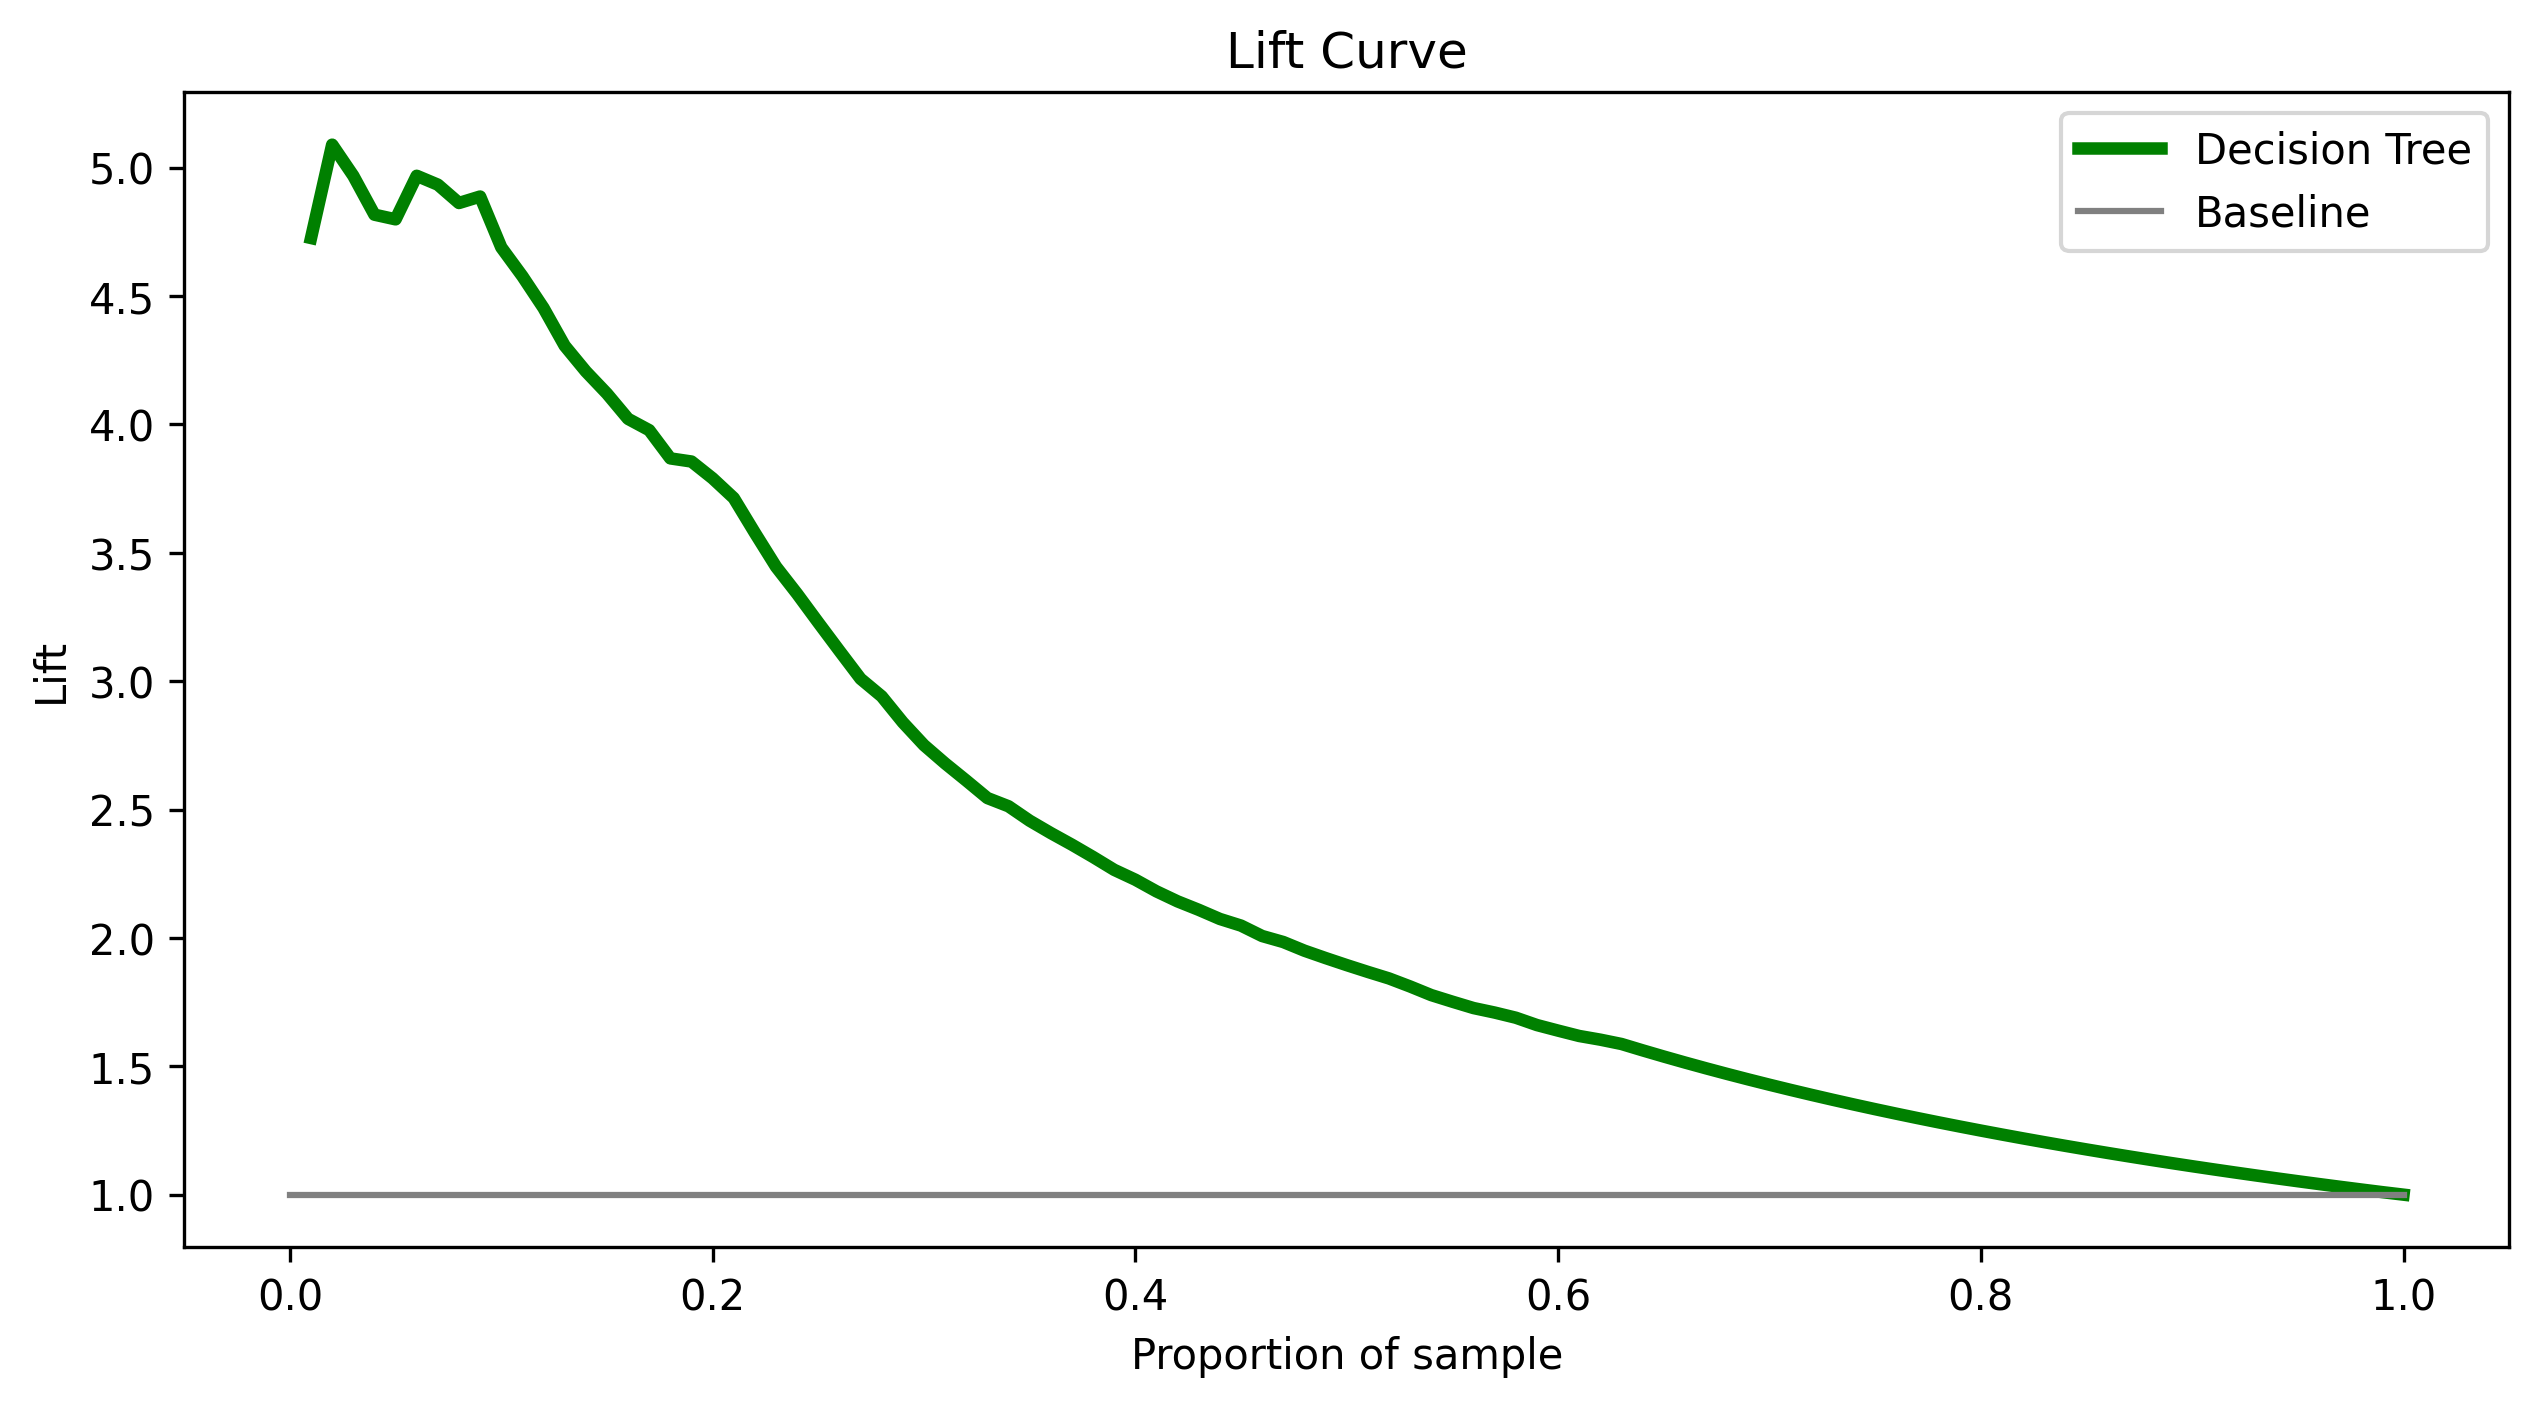

In [22]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
ax.plot(lift_tree["ProportionSample"], lift_tree["Lift"], color="green", linewidth=3, label="Decision Tree")
ax.plot([0,1],[1,1], color="grey", label="Baseline")
ax.set_xlabel("Proportion of sample")
ax.set_ylabel("Lift")
ax.set_title("Lift Curve")
ax.legend()
plt.show()

# Strategies for Improving Model Performance

## Strategy 1: Finding the best model - Hyperparameter Tuning & Cross validation

### 1) Import model functions

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV #randomSearchCV selects combinations randomly, faster and almost as reliable as GridSearchCV
from sklearn.metrics import classification_report

### 2) Define X and y

In [19]:
X = churn.drop("churn",axis=1)
y = churn["churn"]

### 3) Create Test & Training Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 4) Instantiate Model with Cross-Validation Setup

In [24]:
parameters = {"max_depth":range(1,30),
              "min_samples_leaf":[1, 10, 20, 30, 50, 100]}
parameters

{'max_depth': range(1, 30), 'min_samples_leaf': [1, 10, 20, 30, 50, 100]}

In [25]:
tree_CV = GridSearchCV(DecisionTreeClassifier(criterion="entropy", random_state = 1), parameters, cv=10).fit(X_train, y_train)

In [26]:
tree_CV.best_params_

{'max_depth': 6, 'min_samples_leaf': 30}

### 6) Interpret results

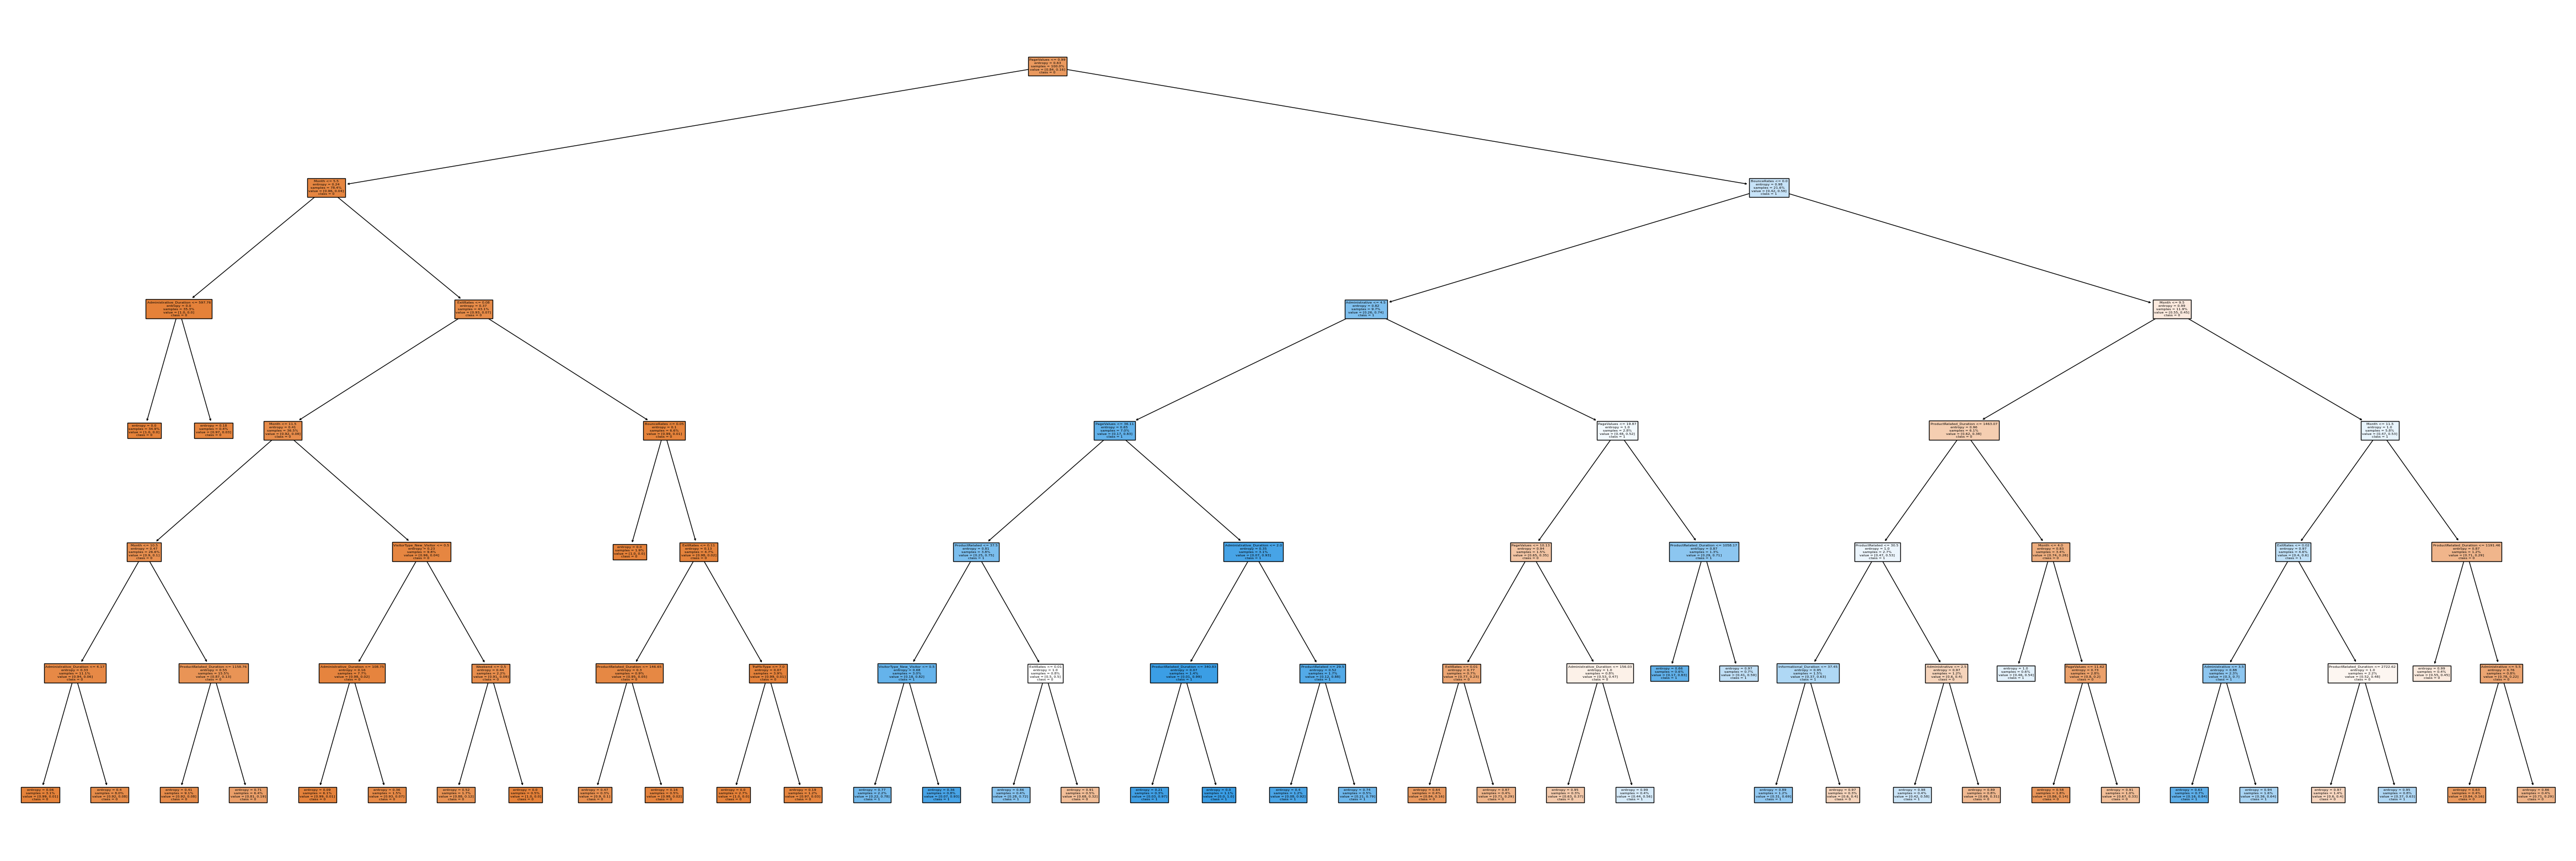

In [27]:
plot_tree_classification(tree_CV.best_estimator_, X_train)

### 7) Evaluate Model

In [28]:
y_pred_class_tree_CV = tree_CV.predict(X_test)
print(classification_report(y_test, y_pred_class_tree_CV))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      3149
         1.0       0.68      0.60      0.64       550

    accuracy                           0.90      3699
   macro avg       0.81      0.77      0.79      3699
weighted avg       0.89      0.90      0.90      3699



In [29]:
y_preds_proba_tree_CV = tree_CV.predict_proba(X_test)
lift_tree_CV = calculate_lift(y_test, y_preds_proba_tree_CV[:,1])

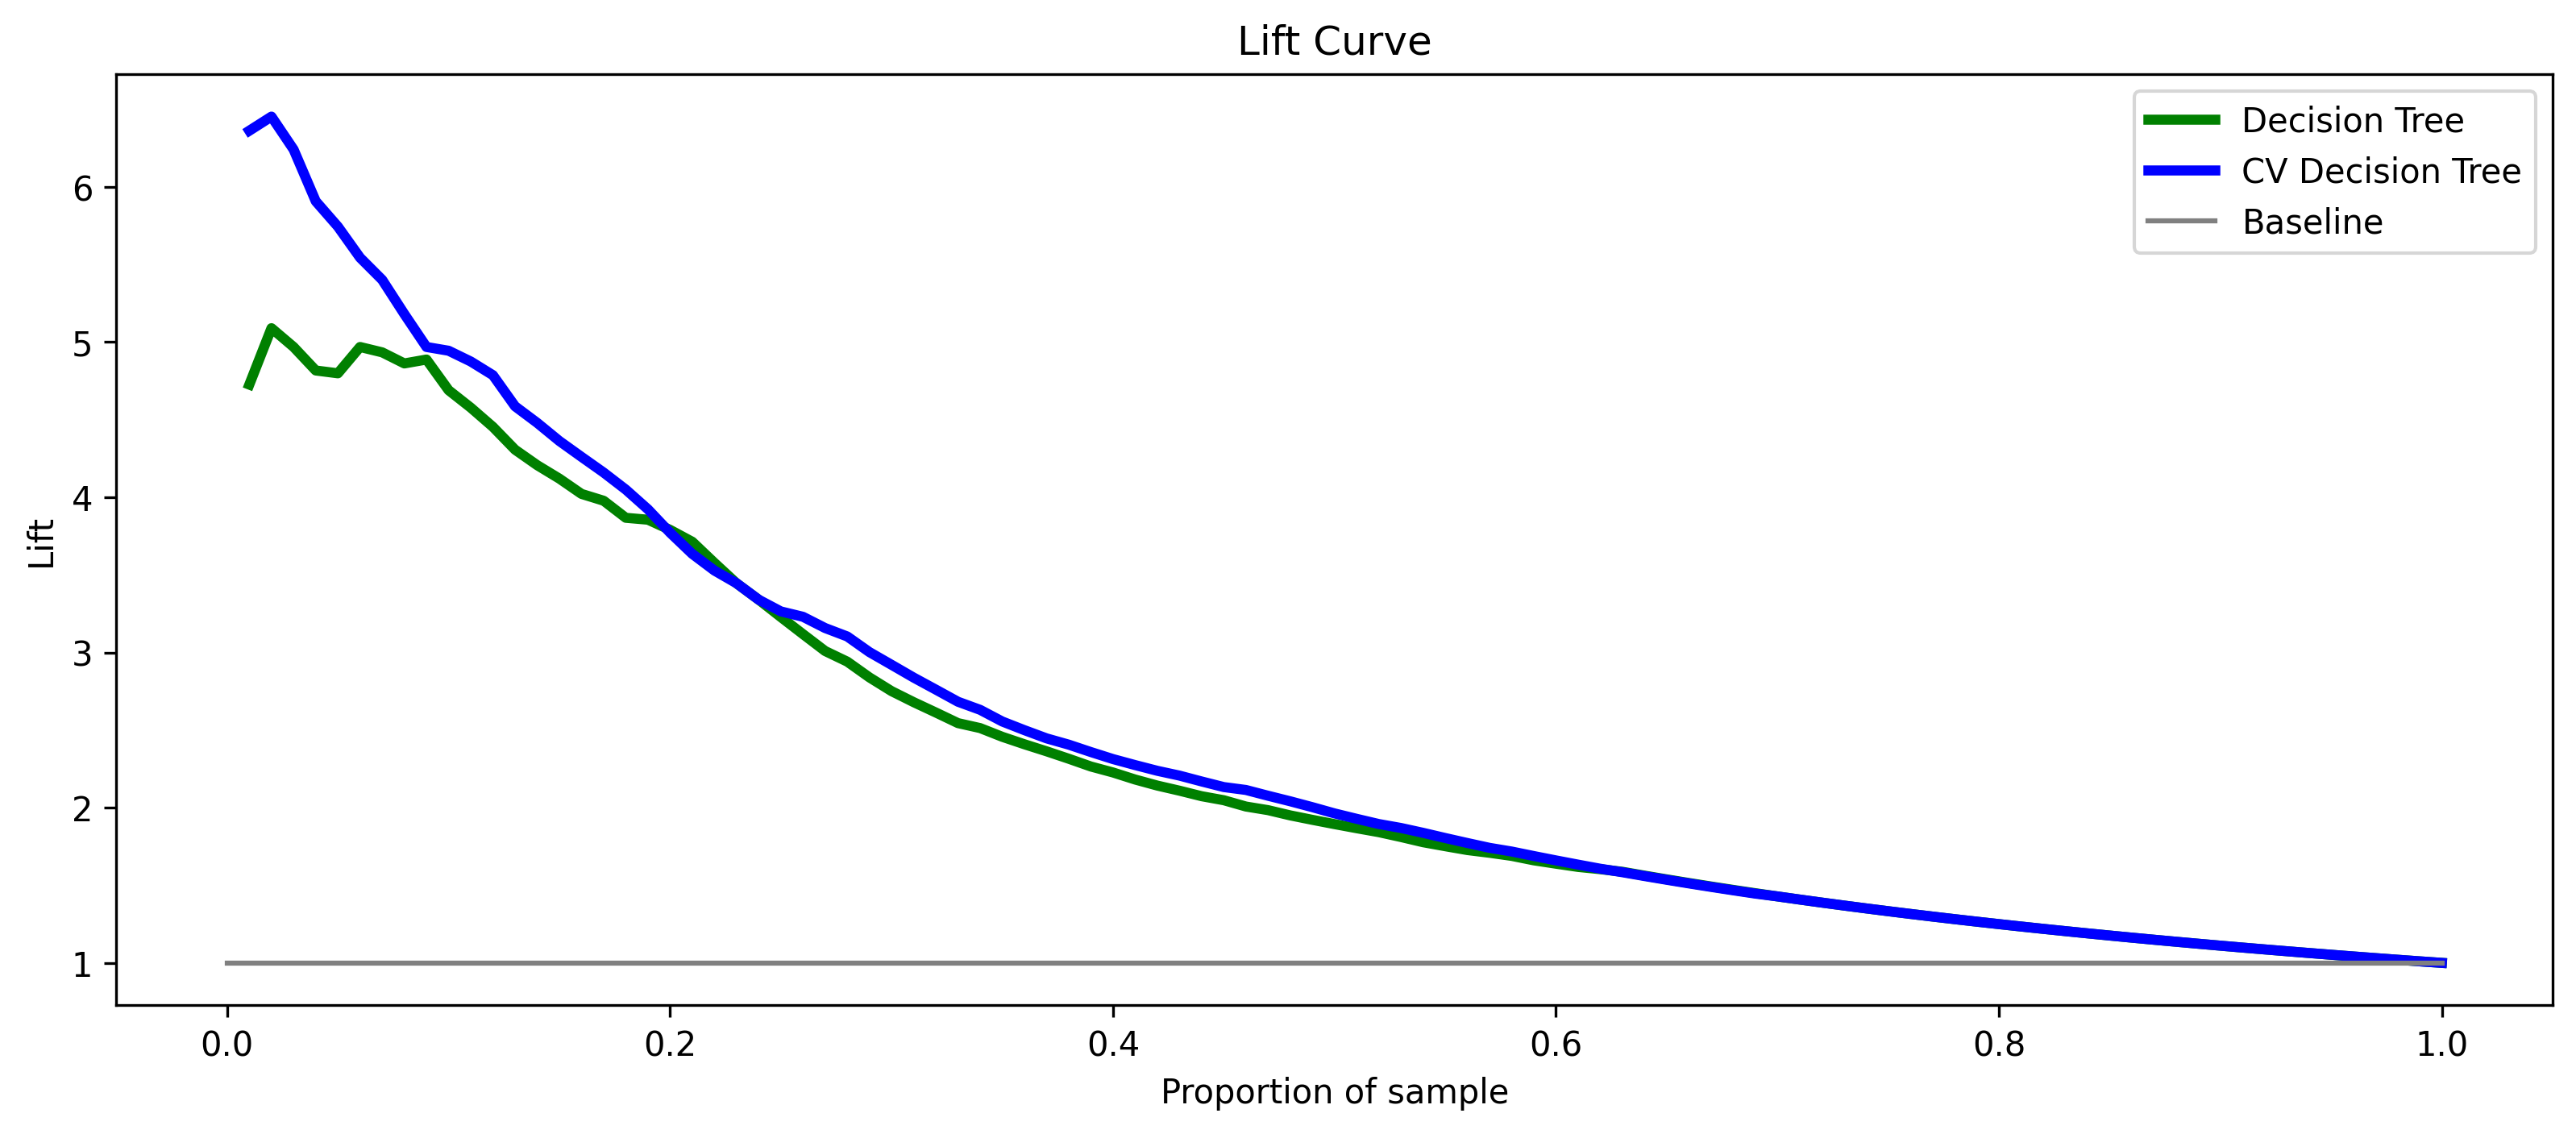

In [30]:
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color="blue", linewidth=3, label = "CV Decision Tree")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

## Strategy 2: Building Many Models - Ensembling (Random Forests)

### 1) Import Model Functions

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2) Define X and y

In [31]:
X = churn.drop("churn",axis=1)
y = churn["churn"]

### 3) Create Training and Test Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 4) Instantiate Model

In [33]:
forest = RandomForestClassifier(n_estimators = 2000).fit(X_train,y_train)

### 6) Interpret results

In [34]:
def plot_variable_importance(model, X_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 

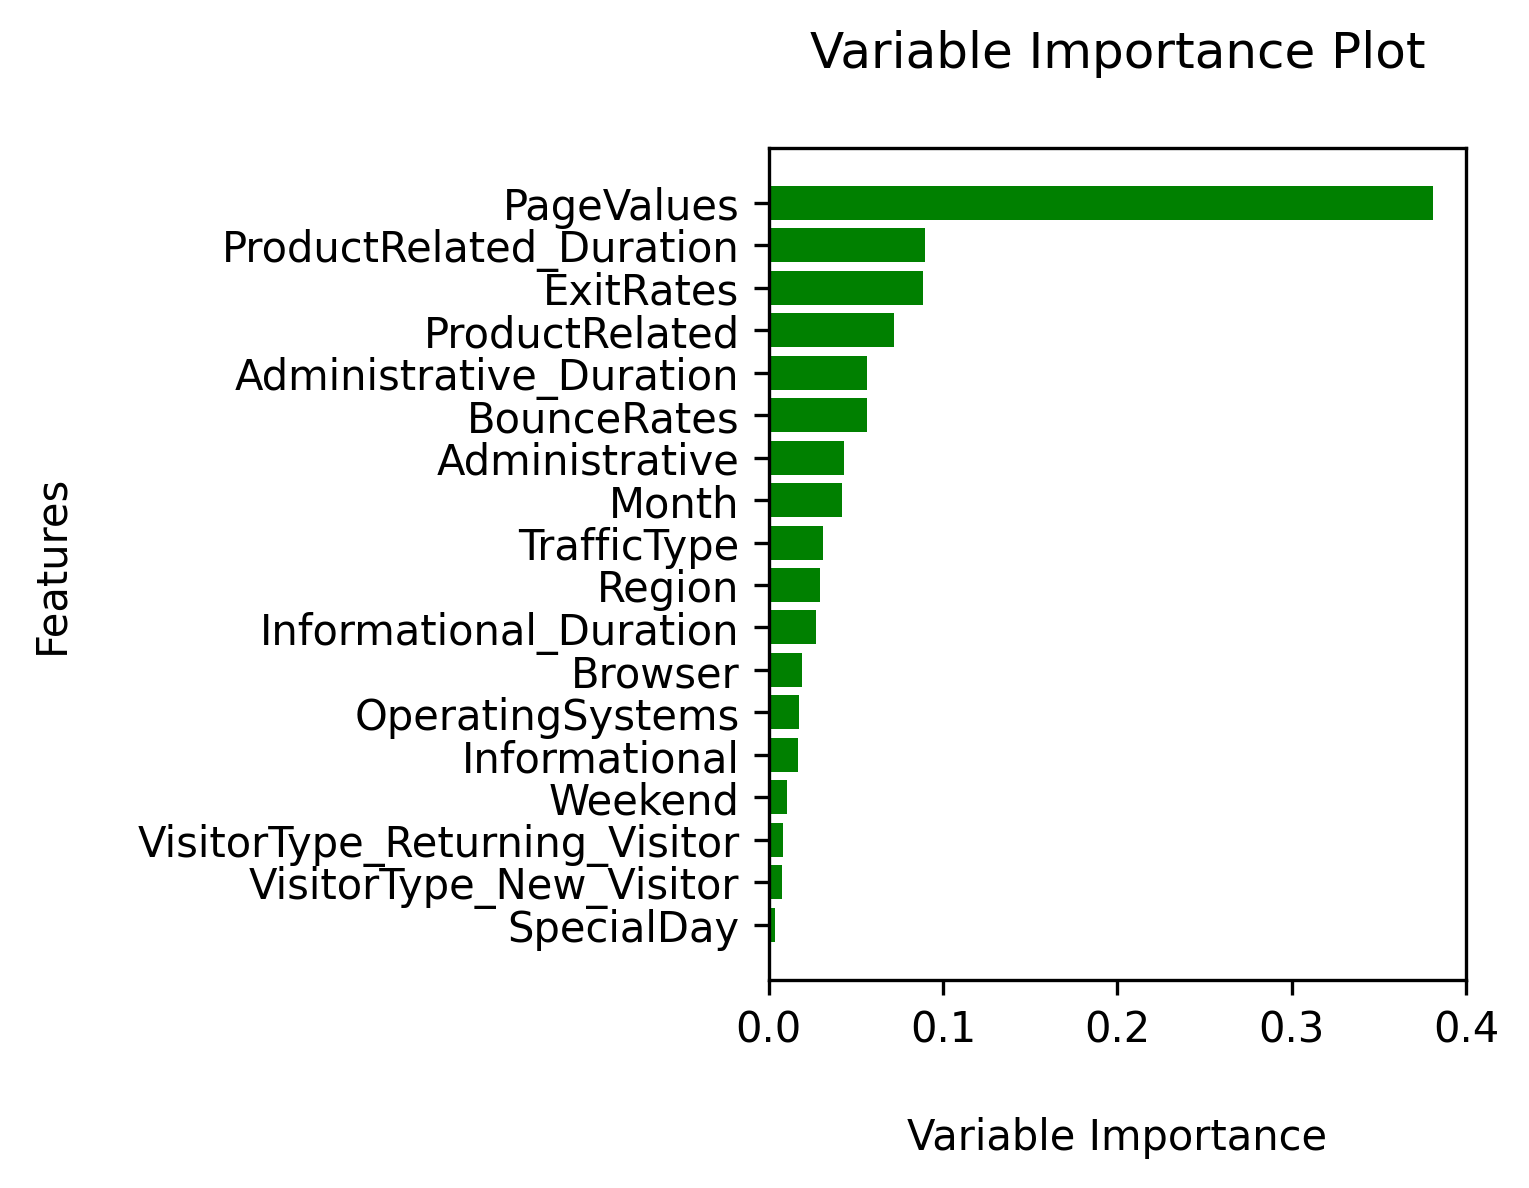

In [35]:
plot_variable_importance(forest, X_train)

In [ ]:
# recursive feature elimination for droping feature with least importance and test whether model performs better,
# continue with second least important feature and so on

### 7) Evaluate Performance 

In [36]:
y_pred_forest = forest.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3149
         1.0       0.72      0.56      0.63       550

    accuracy                           0.90      3699
   macro avg       0.82      0.76      0.79      3699
weighted avg       0.90      0.90      0.90      3699



In [37]:
y_preds_proba_forest = forest.predict_proba(X_test)
lift_forest= calculate_lift (y_test, y_preds_proba_forest[:,1])

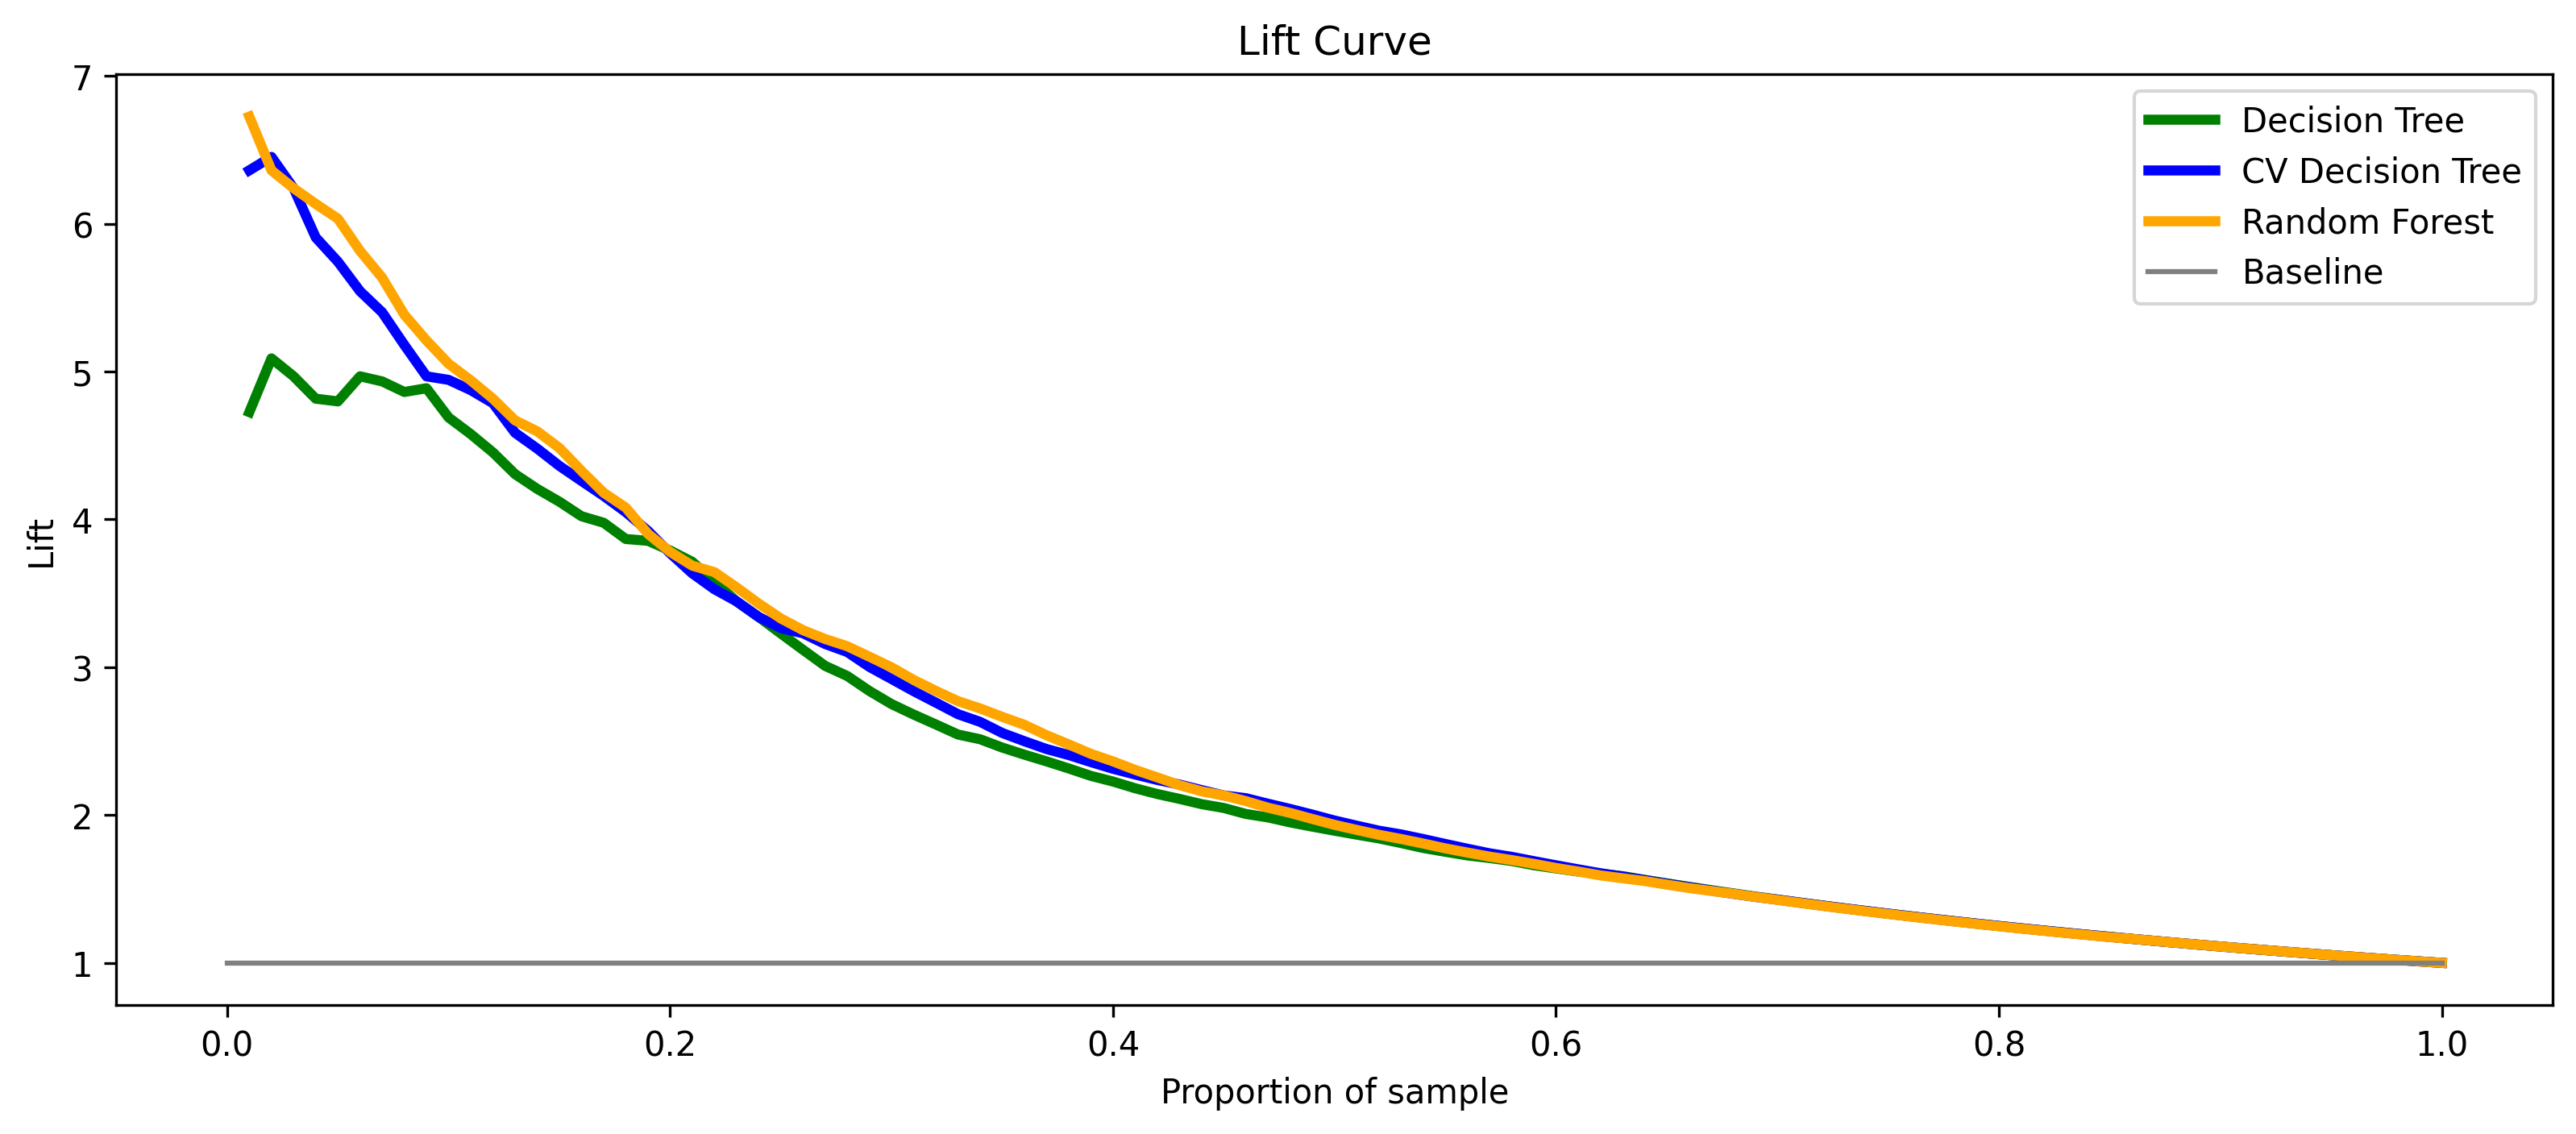

In [38]:
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"], lift_forest["Lift"], color="orange", linewidth = 3, label = "Random Forest" )
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

In [39]:
# recursive feature elimination 
from sklearn.feature_selection import RFE

selector = RFE(RandomForestClassifier(n_estimators=10), n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
selector.support_


array([False,  True, False, False,  True,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False])

In [40]:
X_train.columns
#"Administrative_Duration", "ProductRelated", "ProductRelated_Duration", "ExitRates", "PageValues"

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor'],
      dtype='object')

## Strategy 3: Learning from Past Prediction Errors - Boosting

### 1) Import Model Functions

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 4) Instantiate Model

In [51]:
boost = XGBClassifier(learning_rate = 0.01, n_estimators = 250, random_state = 1).fit(X_train, y_train) 
# learning rate (normalerweise Werte zwischen 0.01-0.1) in kombination mit n_estimators die wichtigsten Hyperparameter

*  **n_estimators:** number of bosted decision trees
*  **learning_rate:** degree to which predictions are updated after each round (usually rather small number between 0.01 and 1)



### 6) Interpret Results

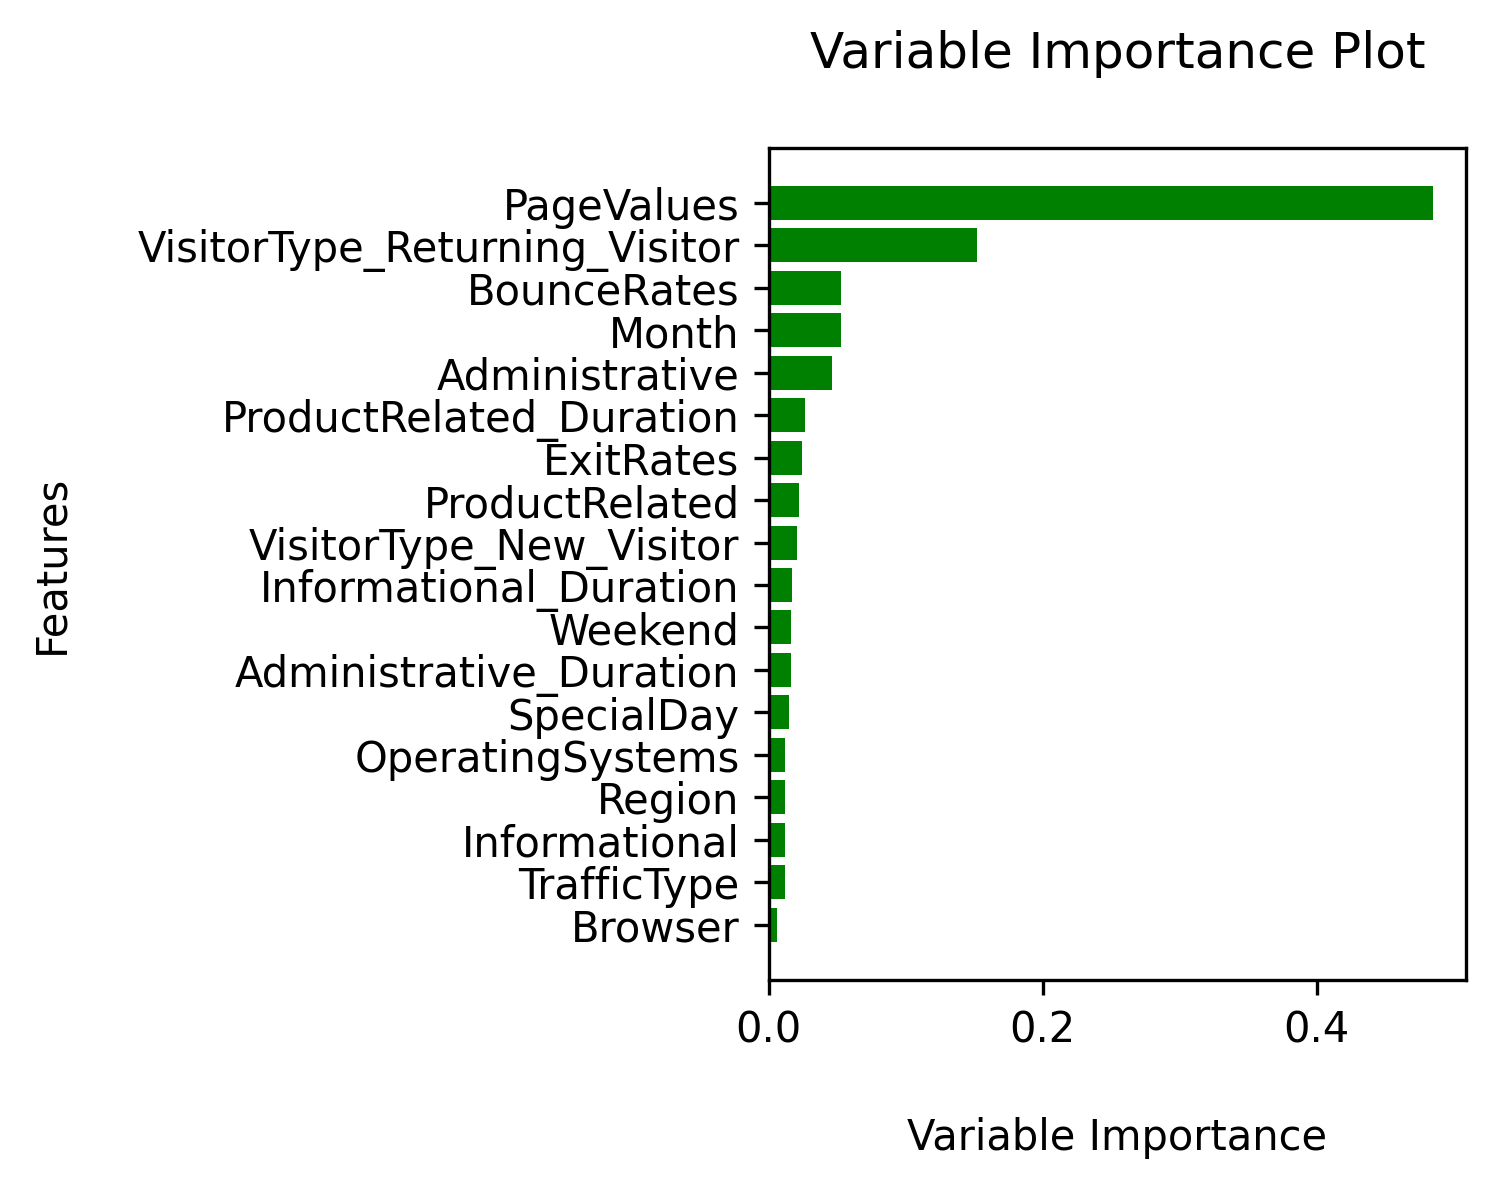

In [52]:
plot_variable_importance(boost, X_train)

### 7) Evaluate Generalization Performance

In [53]:
y_preds_class_boost = boost.predict(X_test)
print(classification_report(y_test,y_preds_class_boost))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3149
         1.0       0.70      0.59      0.64       550

    accuracy                           0.90      3699
   macro avg       0.81      0.77      0.79      3699
weighted avg       0.90      0.90      0.90      3699



Summary of Results

|Model|Accuracy|Recall|Precision|
|--|--|--|--|
|Decision Tree|0.63|0.82|0.49|
|CrossValidated Decision Tree|0.75|0.77|0.63|
|Random Forest|0.84|0.79|0.77|
|Gradient Boosted Trees|0.82|0.83|0.72|

In [54]:
y_preds_proba_boost = boost.predict_proba(X_test)
lift_boost = calculate_lift(y_test, y_preds_proba_boost[:,1])

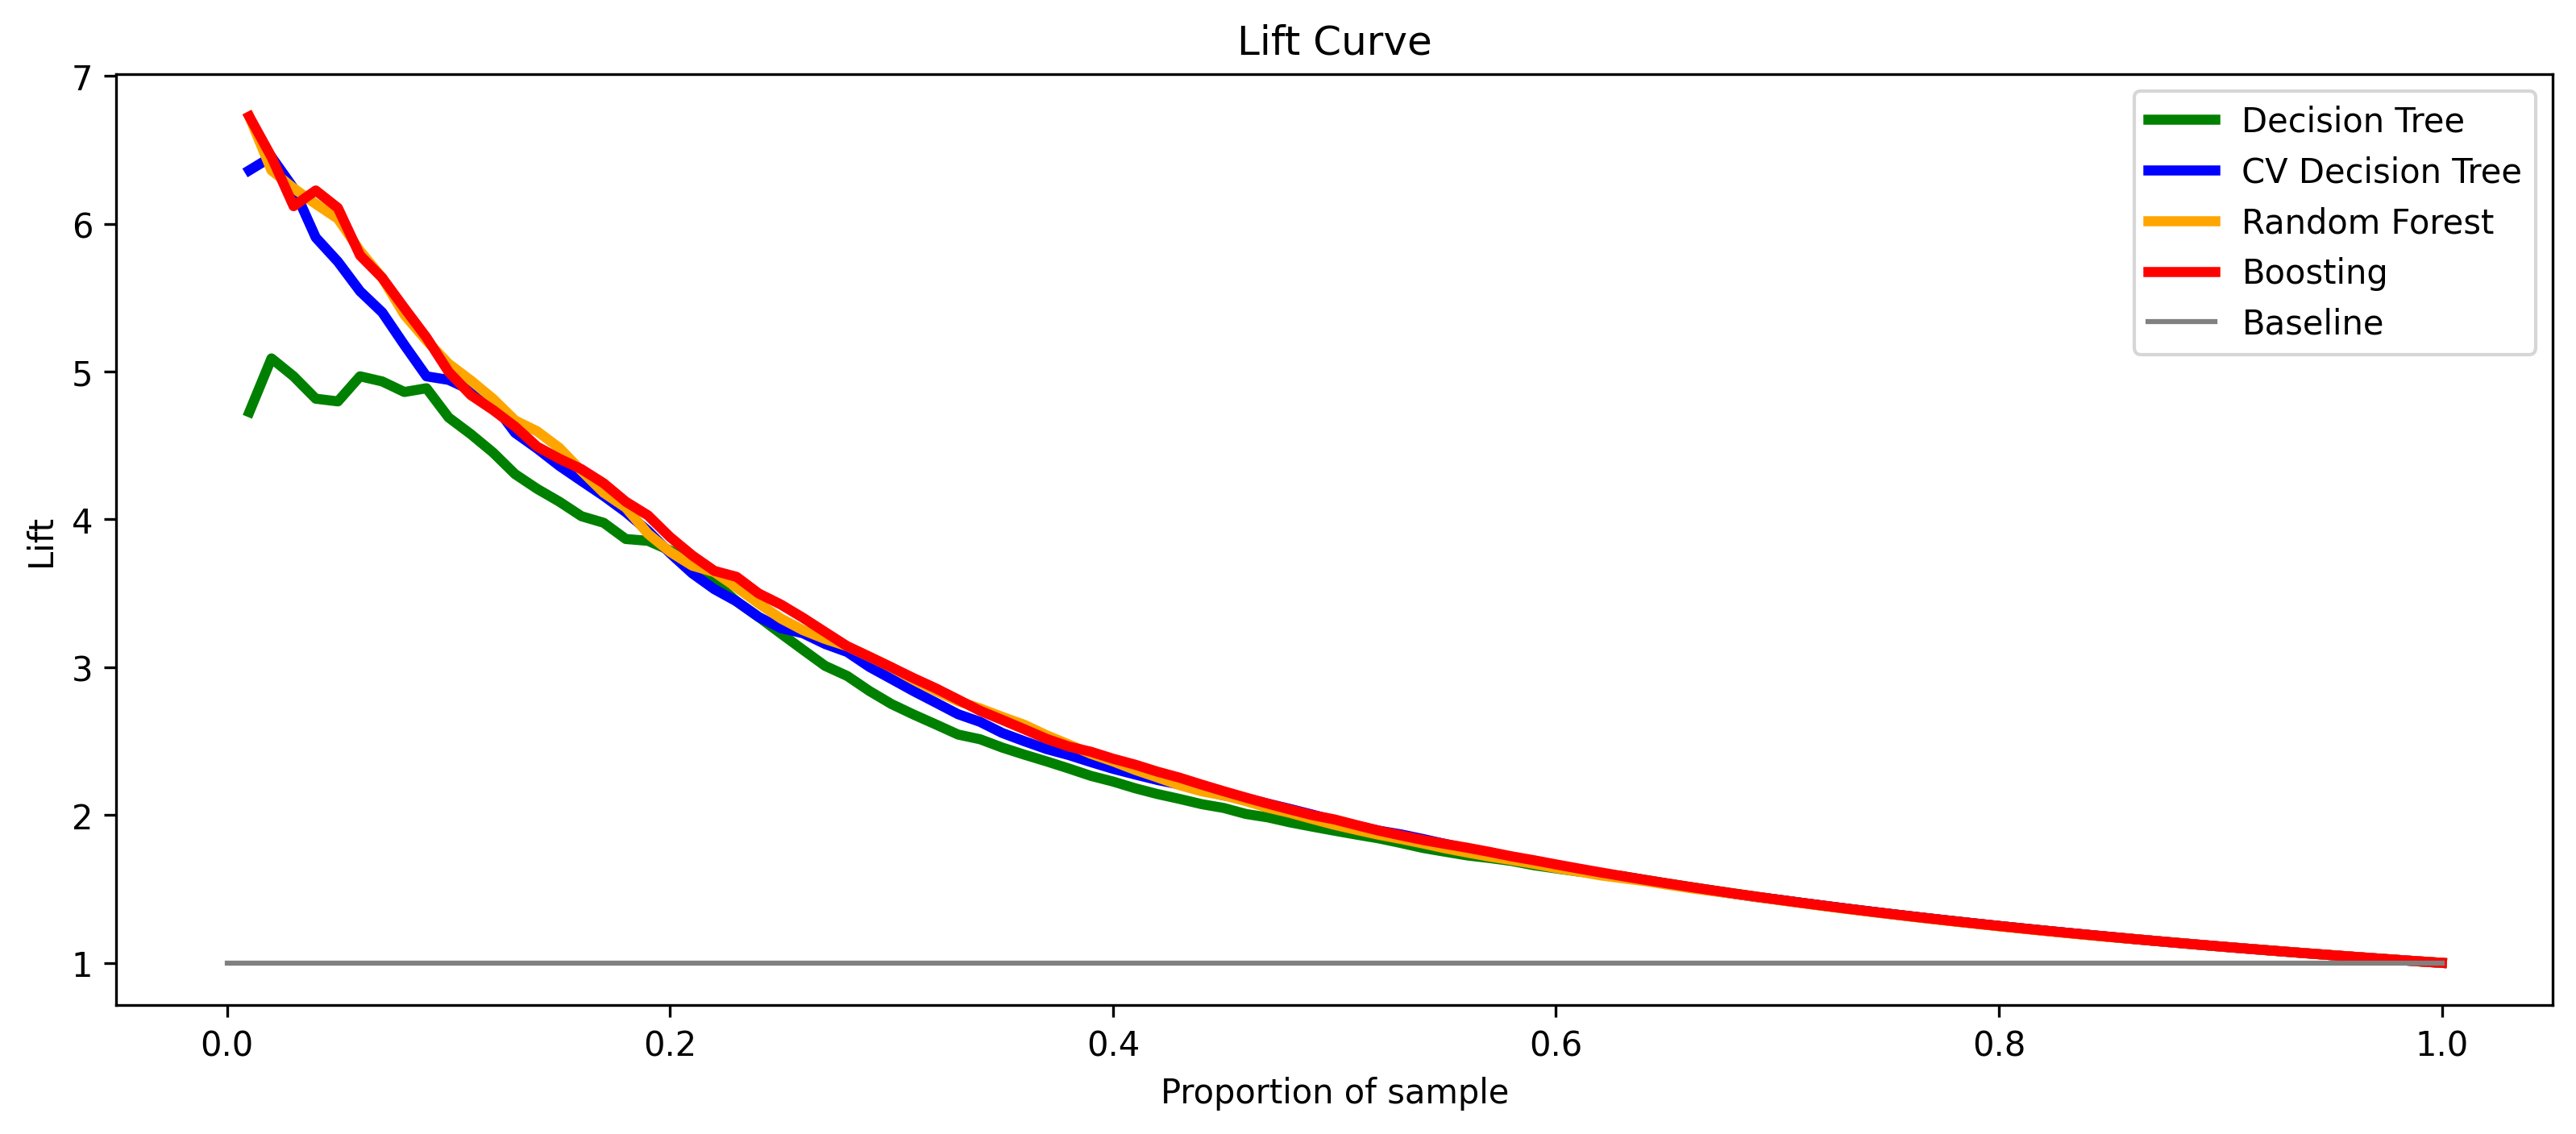

In [55]:
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"],lift_forest["Lift"], color='orange', linewidth = 3, label = "Random Forest")
ax.plot(lift_boost["ProportionSample"], lift_boost["Lift"], color="red", linewidth = 3, label = "Boosting")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

In [ ]:
# stacking um mehrere modelle zu kombinieren und die jeweiligen vorzüge zu nutzen

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [57]:
estimators = [
    ('tree', tree),
    ('tree_CV', tree_CV),
    ('forest', forest),
    ('boost', boost)
]

stack = StackingClassifier(estimators).fit(X_train, y_train)

In [58]:
y_pred_stack = stack.predict(X_test)
print(classification_report(y_test,y_pred_stack))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3149
         1.0       0.71      0.57      0.64       550

    accuracy                           0.90      3699
   macro avg       0.82      0.77      0.79      3699
weighted avg       0.90      0.90      0.90      3699



In [59]:
y_preds_proba_stack = stack.predict_proba(X_test)
lift_stack = calculate_lift(y_test, y_preds_proba_stack[:,1])

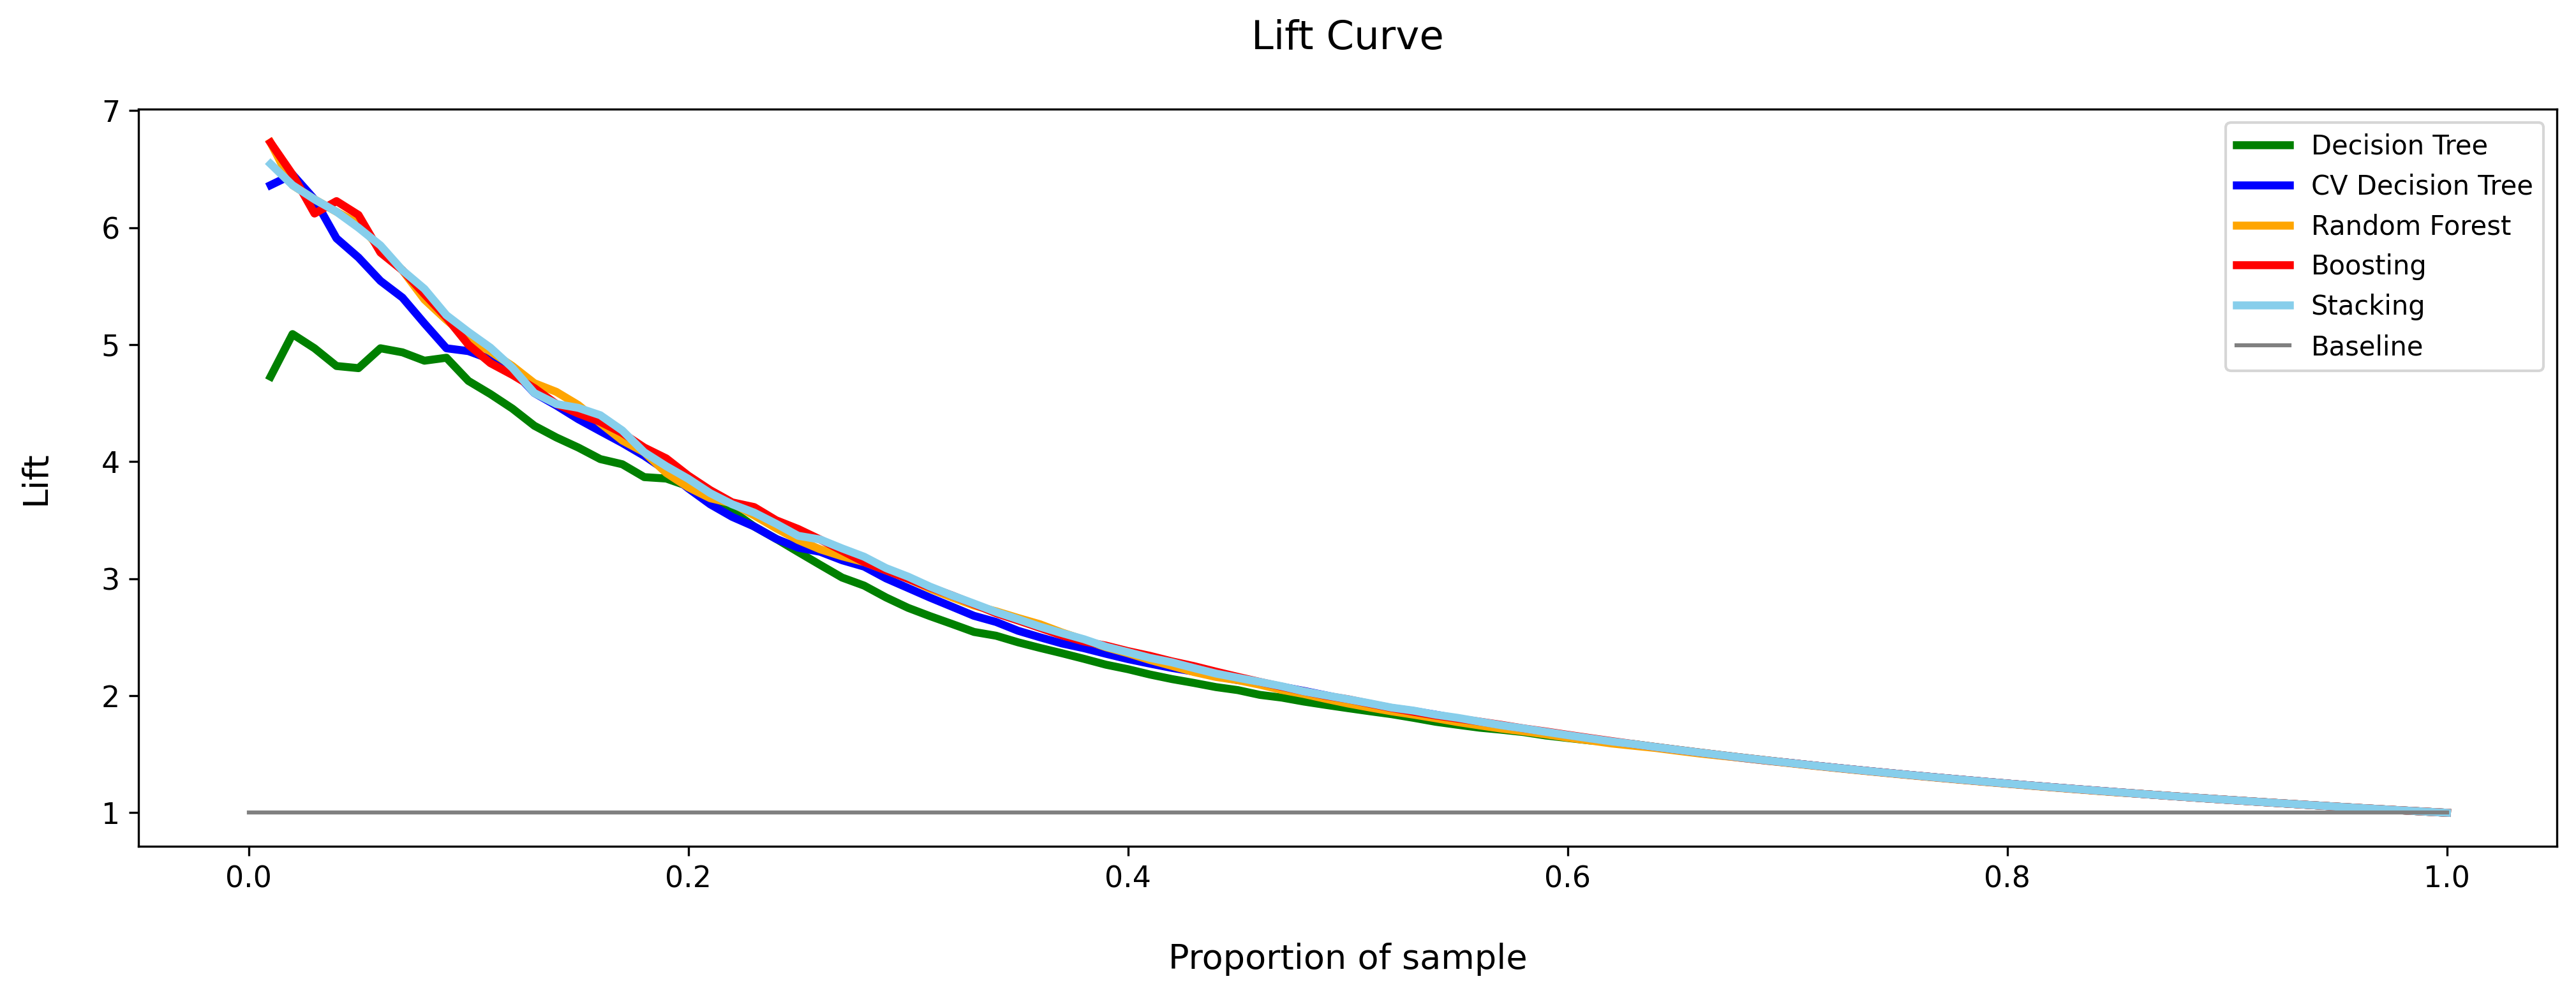

In [61]:
fig, ax = plt.subplots(figsize = (16.3,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"],lift_forest["Lift"], color='orange', linewidth = 3, label = "Random Forest")
ax.plot(lift_boost["ProportionSample"],lift_boost["Lift"], color='red', linewidth = 3, label = "Boosting")
ax.plot(lift_stack["ProportionSample"],lift_stack["Lift"], color='skyblue', linewidth = 3, label = "Stacking")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('\nProportion of sample', fontsize=13)
ax.set_ylabel('Lift\n', fontsize=13)
ax.set_title('Lift Curve\n', fontsize=15)

ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.legend()

plt.show()